In [1]:
from explore_import import  *
import ionbot_preprocess as io
import data_preprocess as dt
import hpp_checker as hpp

import pyteomics.auxiliary as aux
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
project_palette={"canon":"orangered","trembl":"yellowgreen","openprot":"cornflowerblue"}
proteins_palette={"Canonical":"orangered","Non-canonical":"cornflowerblue","Reference isoforms":"yellowgreen","Novel isoforms":"gold"}
project_palette2={"canon":"orangered","trembl":"yellowgreen","openprot":"cornflowerblue",
                "Canon_unique":"salmon", "NonCanon_unique":"skyblue", "Shared":"darkkhaki",
                "Canon":"firebrick","Noncanon":"steelblue","TPP_canon":"lightcoral","TPP_trembl":"greenyellow","TPP_openprot":"paleturquoise",
                  "ionbot_canon":"orangered","ionbot_trembl":"yellowgreen","ionbot_openprot":"cornflowerblue",
                 "TPP_canon_unique":"chocolate",
                  "TPP_canon_unique_shared_in_class":"saddlebrown",
                  "TPP_noncanon_unique":"plum",
                  "TPP_noncanon_unique_shared_in_class":"orchid",
                  "TPP_shared":"tan",
                  "ionbot_canon_unique":"salmon",
                  "ionbot_canon_unique_shared_in_class":"rosybrown",
                  "ionbot_noncanon_unique":"skyblue",
                  "ionbot_noncanon_unique_shared_in_class":"mediumturquoise",
                  "ionbot_shared":"darkkhaki",
                 "ionbot_canon_unique_OnlyMod":"firebrick",
                 "ionbot_canon_unique_OnlyUnmod":"indianred",
                 "ionbot_canon_unique_Both":"lightcoral",
                 "ionbot_noncanon_unique_OnlyMod":"royalblue",
                 "ionbot_noncanon_unique_OnlyUnmod":"dodgerblue",
                 "ionbot_noncanon_unique_Both":"lightblue",
                 "ionbot_shared_OnlyMod":"olivedrab",
                 "ionbot_shared_OnlyUnmod":"olive",
                 "ionbot_shared_Both":"darkseagreen",}

In [3]:
peptide_classes={"NonCanon_unique":["unique_to_Noncanon",'shared_in_Noncanon'],
                "Canon_unique":["unique_to_Canon",'shared_in_Canon'],
                "Shared":['shared_btw_can_noncan']}

In [4]:
global_folder="./../"
working_folder = "./../fromUGhent_v0114_3/"
figsave_folder="./oui_discovery_subfigures/explore-1-group-walk-ionbot-closed/"
wildcard="io_closed"

In [5]:
#list my directory tree
dt.list_files(working_folder)

/
    Comparison-0-group-wise-protgroups-20250417-closed.svg
    Comparison-0-group-wise-protgroups-20250417.svg
    2025-04-18-ionbot-results.zip
    ID-rates-2.svg
    FDR-levels.svg
    ID-rates-1.svg
    PSM-counts.svg
PXD014258-closed/
    Metadata_PXD014258-closed-trembl.txt
    Metadata_PXD014258-closed-canon.txt
    Metadata_PXD014258-closed-open.txt
    PXD014258-closed-openprot/
        PXD014258-closed-openprot-combined-results.csv
        target-decoy-plot.png
        group-walk-output.csv
        Sample-BT474-closed-open/
            subgroups_Occam.tsv
            sample_protein_groups_Occam.csv
            ionbot.first.proteins.csv
            ionbot.first.csv
            ionbot.meta.csv
            groups_Occam.tsv
            ionbot.features.csv
            ionbot.first.peptides.csv
            ionbot.stats.csv
            sample-protein-inference-input.pout
            ionbot.modifications.csv
        Sample-MCF-closed-open/
            ionbot.first.proteins.csv
     

In [6]:
OPfasta_file='./../ionbot_openprot/openprot_2_0_0-human-ensembl106+refseq+uniprot2022_06_01.fasta'
input_file = open(OPfasta_file)
OPfasta = SeqIO.to_dict(SeqIO.parse(OPfasta_file, "fasta"))

In [7]:
mgfspectraN_datasets=pickle.load(open('./../mgfspectraN_datasets.pickle', 'rb'))

In [8]:
def classify_leadprot(x):
    if 'CONTAMINANT' in x.upper():
        return 'Contam'
    elif x.startswith('II_') or x.startswith('IP_'):
        return 'NonCanon'
        # Ensembl is canonical
    else:
        return 'Canon'

def is_peptide_canonical(x):
    '''x is the list of protein classes'''
    if np.array([_=='Contam' for _ in x]).any():
        return 'Contam'
    if np.array([_=='Canon' for _ in x]).any():
        return 'Canonical'
    return 'NonCanonical'

def classifiy_mods(row):
    if row.modifications=='Unmodified':
        return 'Unmodified'
    elif len(row.unexpected_modification)>1:
        return 'Unexpected'
    else:
        return 'Expected'

def custom_subgroup_filter(data_):
    filtered_subgroups = []
    for (c,m),df in data_.groupby(['isCanonical','isModified']).__iter__():
        tmp = aux.target_decoy.qvalues(df, key='psm_score', reverse=True, is_decoy=df.database=='D',
                                      formula=1, full_output=True, q_label='custom_q')
        filtered_subgroups.append(tmp)

    return pd.concat(filtered_subgroups, ignore_index=True)

### Load PSM level

In [9]:
combined_first_datasets={"PXD002057":0,"PXD005833":0,"PXD014258":0}
sufix="-combined-results.csv"
combined_first_datasets["PXD002057"]=io.load_combined_first(working_folder,"PXD002057-closed",sufix)
combined_first_datasets["PXD005833"]=io.load_combined_first(working_folder,"PXD005833-closed",sufix)
combined_first_datasets["PXD014258"]=io.load_combined_first(working_folder,"PXD014258-closed",sufix)

### Global, cutom and hybrid FDR

In [10]:
for dataset_name in combined_first_datasets:
    for database in combined_first_datasets[dataset_name]:
        df_ds=combined_first_datasets[dataset_name][database]
        df_ds_new=[]
        for spectrum_file in set(df_ds.spectrum_file):
            data=df_ds.loc[df_ds.spectrum_file==spectrum_file]
            data = aux.target_decoy.qvalues(data, key='psm_score', reverse=True, is_decoy=data.database=='D',
                                    q_label='global_q',
                                    formula=1, full_output=True)
            data.sort_values('database', ascending=False, inplace=True)
            data.unexpected_modification = data.unexpected_modification.fillna('')
            #process proteins names
            data["proteins_list"] = data.proteins.str.split('||', regex=False)
            # if peptide maps to >100 proteins, only consider the first 100
            data.proteins_list = data.proteins_list.apply(lambda x: x[:100] if len(x)>100 else x)
            # protein format = 'P60981-2((116-129))((P60981-2))' --> split on the parenthesis, take 4th element
            data.proteins_list = data.proteins_list.apply(lambda x: [re.split(r'\(\(|\)\)', _)[3] for _ in x])
            
            data['protein_classes'] = data.proteins_list.apply(lambda x: np.unique([classify_leadprot(_) for _ in x]))
            data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
            data['isModified']  = data.apply(classifiy_mods,axis=1)
        
            # Adds a columns telling you if a PSM passes the custom filters or not (custom_filter_pass)
            data2 = custom_subgroup_filter(data)
            del data
        
            # prepare for Group-walk
            data2['isTarget'] = data2.database.apply(lambda x: int(x=='T'))
            data2['FDRGroup'] = data2.isCanonical + '_' + data2.isModified
            #add hybrid
            data2["glob_cust_hybrid"]=data2.apply(lambda x: x.custom_q if x.isCanonical=="NonCanonical" else x.global_q, axis=1)
            #indicate best PSM per peptide
            psm_score_best=data2.groupby("database_peptide")["psm_score"].apply(lambda x: x.max())
            data2["psm_score_isBest"]=data2.apply(lambda x: x["psm_score"]==psm_score_best[x["database_peptide"]], axis=1)
            #indicate modification type per peptide
            mod_type=data2.groupby("database_peptide")["isModified"].apply(lambda x: "Unexpected" if "Unexpected" in set(x) 
                                                                          else "Expected" if "Expected" in set(x)
                                                                          else "Unmodified")
            data2["database_peptide_isModified"]=data2.apply(lambda x: mod_type[x["database_peptide"]], axis=1)
            
            df_ds_new.append(data2)
        combined_first_datasets[dataset_name][database]=pd.concat(df_ds_new)

/home/vvshazia/miniconda3/envs/general/lib/python3.13/site-packages/pyteomics/auxiliary/target_decoy.py:83: RuntimeWarning: divide by zero encountered in divide
  q = tfalse / (ind - cumsum) / ratio


In [11]:
with open('closed_combined_first_datasets.pickle', 'wb') as handle:
    pickle.dump(combined_first_datasets, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [12]:
#control
for dataset_name in combined_first_datasets:
    for database in combined_first_datasets[dataset_name]:
        df=combined_first_datasets[dataset_name][database]
        print(dataset_name,database,len(df[df.database=="T"].spectrum_file.unique()),df[df.database=="T"].spectrum_file.value_counts())

PXD002057 canon 6 spectrum_file
130327_o2_02_hu_P1_2hr.mgf    8516
130327_o2_06_hu_P3_2hr.mgf    7508
130327_o2_04_hu_P2_2hr.mgf    7374
130327_o2_01_hu_C1_2hr.mgf    6074
130327_o2_05_hu_C3_2hr.mgf    4898
130327_o2_03_hu_C2_2hr.mgf    4814
Name: count, dtype: int64
PXD002057 trembl 6 spectrum_file
130327_o2_02_hu_P1_2hr.mgf    7428
130327_o2_06_hu_P3_2hr.mgf    6562
130327_o2_04_hu_P2_2hr.mgf    6326
130327_o2_01_hu_C1_2hr.mgf    4749
130327_o2_05_hu_C3_2hr.mgf    3833
130327_o2_03_hu_C2_2hr.mgf    3804
Name: count, dtype: int64
PXD002057 openprot 6 spectrum_file
130327_o2_02_hu_P1_2hr.mgf    7991
130327_o2_06_hu_P3_2hr.mgf    7230
130327_o2_04_hu_P2_2hr.mgf    7022
130327_o2_01_hu_C1_2hr.mgf    5463
130327_o2_05_hu_C3_2hr.mgf    4477
130327_o2_03_hu_C2_2hr.mgf    4438
Name: count, dtype: int64
PXD005833 canon 15 spectrum_file
AM16.mgf    11712
AM12.mgf    11113
AM19.mgf    10198
AM13.mgf     9979
AM9.mgf      9926
AM11.mgf     9596
AM14.mgf     9392
AM10.mgf     9036
AM18.mgf     86

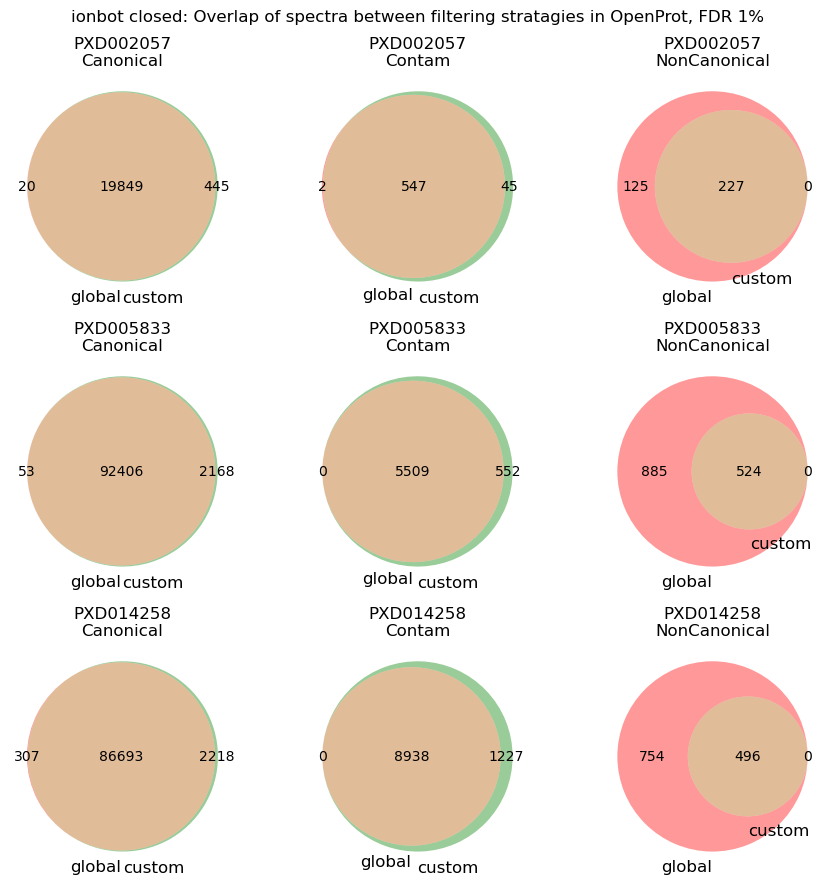

In [13]:
fig, axes = plt.subplots(3,3, figsize=(9, 9))
fig.suptitle("ionbot closed: Overlap of spectra between filtering stratagies in OpenProt, FDR 1%")

for i,(dataset, subdict) in enumerate(combined_first_datasets.items()):
    data=subdict["openprot"]
    for j,(isCanonical,group) in enumerate(data.groupby("isCanonical")):
        glob=group[group['global_q']<0.01].spectrum_title
        cust=group[group['custom_q']<0.01].spectrum_title
        venn2((set(glob), set(cust)), set_labels=('global', 'custom'), ax=axes[i,j])
        axes[i,j].set_title(f"{dataset}\n{isCanonical}")
plt.tight_layout()

### Load peptide level, calculate global and custom FDR, filter decoy and contominant

In [14]:
fix_spectrum_file={"PXD002057":{
                    "canon":{'130327_o2_06_hu_P3_2hr-closed-canon':'130327_o2_06_hu_P3_2hr.mgf',
                            '130327_o2_02_hu_P1_2hr-closed-canon':'130327_o2_02_hu_P1_2hr.mgf',
                              '130327_o2_03_hu_C2_2hr-closed-canon':'130327_o2_03_hu_C2_2hr.mgf',
                               '130327_o2_05_hu_C3_2hr-closed-canon':'130327_o2_05_hu_C3_2hr.mgf',
                              '130327_o2_01_hu_C1_2hr-closed-canon':'130327_o2_01_hu_C1_2hr.mgf',
                              '130327_o2_04_hu_P2_2hr-closed-canon':'130327_o2_04_hu_P2_2hr.mgf'},
                   "trembl":{'130327_o2_06_hu_P3_2hr-closed-trembl':'130327_o2_06_hu_P3_2hr.mgf',
                            '130327_o2_02_hu_P1_2hr-closed-trembl':'130327_o2_02_hu_P1_2hr.mgf',
                              '130327_o2_03_hu_C2_2hr-closed-trembl':'130327_o2_03_hu_C2_2hr.mgf',
                               '130327_o2_05_hu_C3_2hr-closed-trembl':'130327_o2_05_hu_C3_2hr.mgf',
                              '130327_o2_01_hu_C1_2hr-closed-trembl':'130327_o2_01_hu_C1_2hr.mgf',
                              '130327_o2_04_hu_P2_2hr-closed-trembl':'130327_o2_04_hu_P2_2hr.mgf'},
                   "openprot":{'130327_o2_06_hu_P3_2hr-closed-open':'130327_o2_06_hu_P3_2hr.mgf',
                            '130327_o2_02_hu_P1_2hr-closed-open':'130327_o2_02_hu_P1_2hr.mgf',
                              '130327_o2_03_hu_C2_2hr-closed-open':'130327_o2_03_hu_C2_2hr.mgf',
                               '130327_o2_05_hu_C3_2hr-closed-open':'130327_o2_05_hu_C3_2hr.mgf',
                              '130327_o2_01_hu_C1_2hr-closed-open':'130327_o2_01_hu_C1_2hr.mgf',
                              '130327_o2_04_hu_P2_2hr-closed-open':'130327_o2_04_hu_P2_2hr.mgf'}},
                    "PXD005833":{
                        "canon":{'AM16-canon':'AM16.mgf', 
                                 'AM21-canon':'AM21.mgf', 
                                 'AM17-canon':'AM17.mgf', 
                                 'AM20-canon':'AM20.mgf', 
                                 'AM18-canon':'AM18.mgf', 
                                 'AM14-canon':'AM14.mgf', 
                                 'AM19-canon':'AM19.mgf', 
                                 'AM15-canon':'AM15.mgf', 
                                 'AM12-canon':'AM12.mgf', 
                                 'AM8-canon':'AM8.mgf', 
                                 'AM9-canon':'AM9.mgf',
                                 'AM13-canon':'AM13.mgf',
                                 'AM10-canon':'AM10.mgf', 
                                 'AM11-canon':'AM11.mgf', 
                                 'AM7-canon':'AM7.mgf'},
                        "trembl":{'AM16-trembl':'AM16.mgf', 
                                 'AM21-trembl':'AM21.mgf', 
                                 'AM17-trembl':'AM17.mgf', 
                                 'AM20-trembl':'AM20.mgf', 
                                 'AM18-trembl':'AM18.mgf', 
                                 'AM14-trembl':'AM14.mgf', 
                                 'AM19-trembl':'AM19.mgf', 
                                 'AM15-trembl':'AM15.mgf', 
                                 'AM12-trembl':'AM12.mgf', 
                                 'AM8-trembl':'AM8.mgf', 
                                 'AM9-trembl':'AM9.mgf',
                                 'AM13-trembl':'AM13.mgf',
                                 'AM10-trembl':'AM10.mgf', 
                                 'AM11-trembl':'AM11.mgf', 
                                 'AM7-trembl':'AM7.mgf'},
                        "openprot":{'AM16-openprot':'AM16.mgf', 
                                 'AM21-openprot':'AM21.mgf', 
                                 'AM17-openprot':'AM17.mgf', 
                                 'AM20-openprot':'AM20.mgf', 
                                 'AM18-openprot':'AM18.mgf', 
                                 'AM14-openprot':'AM14.mgf', 
                                 'AM19-openprot':'AM19.mgf', 
                                 'AM15-openprot':'AM15.mgf', 
                                 'AM12-openprot':'AM12.mgf', 
                                 'AM8-openprot':'AM8.mgf', 
                                 'AM9-openprot':'AM9.mgf',
                                 'AM13-openprot':'AM13.mgf',
                                 'AM10-openprot':'AM10.mgf', 
                                 'AM11-openprot':'AM11.mgf', 
                                 'AM7-openprot':'AM7.mgf'}
                    },
                    "PXD014258":{
                                            "canon":{'Sample-BT474-closed-canon':'ESC-HF-Sample-BT474_merged.mgf', 
                                                     'SampleHela-closed-canon':'ESC-HF-Sample-MCF_merged.mgf', 
                                                     'Sample-MCF-closed-canon':'ESC-HF-SampleHela_merged.mgf'},
                                            "trembl":{'Sample-BT474-closed-trembl':'ESC-HF-Sample-BT474_merged.mgf', 
                                                      'SampleHela-closed-trembl':'ESC-HF-Sample-MCF_merged.mgf', 
                                                      'Sample-MCF-closed-trembl':'ESC-HF-SampleHela_merged.mgf'},
                                            "openprot":{'Sample-BT474-closed-open':'ESC-HF-Sample-BT474_merged.mgf', 
                                                        'Sample-MCF-closed-open':'ESC-HF-Sample-MCF_merged.mgf', 
                                                        'SampleHela-closed-open':'ESC-HF-SampleHela_merged.mgf'}}}

In [15]:
def combine_ionbot(working_folder, dataset_name, db_sufix,file_name):
    #several folders, representing samples, containe ionbot results
    dir=os.path.join(working_folder, dataset_name, f'{dataset_name}{db_sufix}')
    print(dir)
    toread=[os.path.join(lvl1[0],file_name) for lvl1 in os.walk(os.path.join(working_folder, dataset_name, f'{dataset_name}{db_sufix}')) if len(lvl1[0].split("/"))==6 and file_name in lvl1[2]]   
    print(toread)
    combined=pd.DataFrame()
    #print(dir)
    #print(toread)
    for file in toread:
        #print(file)
        #print(file.lstrip(dir).rstrip(file_name))
        a=pd.read_csv(file)
        a['spectrum_file']=file.split("/")[-2]#file.lstrip(dir).rstrip(file_name)
        combined=pd.concat([combined,a])
    return combined

In [21]:
#load peptides files, filter  by qvalue and contaminants by proteins

combined_peptides_datasets={"PXD002057":0,"PXD005833":0,"PXD014258":0}
for dataset_name in combined_peptides_datasets:
    #if dataset_name!="PXD014258.v0.11.4": continue
    combined_peptides={"canon":0,"trembl":0,"openprot":0}
    for database in combined_peptides:
        df=combine_ionbot(working_folder, f"{dataset_name}-closed", f"-{database}","ionbot.first.peptides.csv")
        ##continue
        df["database"]=df.proteins.apply(lambda x: "D" if "decoy" in x else "T")
        df_ds_new=[]
        df_psm=combined_first_datasets[dataset_name][database]
        #fix spectrum file
        print(set(df.spectrum_file))
        for spf_now,spf_right in fix_spectrum_file[dataset_name][database].items():
            print(spf_now,spf_right)
            df.loc[df.spectrum_file==spf_now,"spectrum_file"]=spf_right
        print(set(df.spectrum_file))
        for spectrum_file in set(df.spectrum_file):
            data=df.loc[df.spectrum_file==spectrum_file]
            if dataset_name!="PXD014258": 
                data_psm=df_psm.loc[df_psm.spectrum_file==spectrum_file]
            else:
                data_psm=df_psm
            #get best psm score of peptide
            psm_score_best=data_psm[data_psm.psm_score_isBest][["database_peptide","psm_score"]].drop_duplicates()
            #psm_score_best.rename(columns={'psm_score_isBest': 'psm_score'}, inplace=True)
            print(len(data))
            data=data.merge(psm_score_best, on="database_peptide", how='left')
            print(len(data))
            #data["psm_score"]=data.database_peptide.apply(lambda x: data_psm[(data_psm.database_peptide==x)&(data_psm.psm_score_isBest)].psm_score.iloc[0])
            
            #get modification status
            psm_ismod=data_psm[["database_peptide","database_peptide_isModified"]].drop_duplicates()
            psm_ismod.rename(columns={'database_peptide_isModified': 'isModified'}, inplace=True)
            print(len(data))
            data=data.merge(psm_ismod, on="database_peptide", how='left')
            print(len(data))
            #data["isModified"]=data.database_peptide.apply(lambda x: data_psm[(data_psm.database_peptide==x)].database_peptide_isModified.iloc[0])
            
            data = aux.target_decoy.qvalues(data, key='psm_score', reverse=True, is_decoy=data.database=='D',
                                    q_label='global_q',
                                    formula=1, full_output=True)
            data.sort_values('database', ascending=False, inplace=True)
            ##data.unexpected_modification = data.unexpected_modification.fillna('')
            #process proteins names
            data["proteins_list"] = data.proteins.str.split('||', regex=False)
            # if peptide maps to >100 proteins, only consider the first 100
            data.proteins_list = data.proteins_list.apply(lambda x: x[:100] if len(x)>100 else x)
            # protein format = 'P60981-2((116-129))((P60981-2))' --> split on the parenthesis, take 4th element
            data.proteins_list = data.proteins_list.apply(lambda x: [re.split(r'\(\(|\)\)', _)[3] for _ in x])
            
            data['protein_classes'] = data.proteins_list.apply(lambda x: np.unique([classify_leadprot(_) for _ in x]))
            data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
            ##data['isModified']  = data.apply(classifiy_mods,axis=1)
        
            # Adds a columns telling you if a PSM passes the custom filters or not (custom_filter_pass)
            data2 = custom_subgroup_filter(data)
            del data
        
            # prepare for Group-walk
            data2['isTarget'] = data2.database.apply(lambda x: int(x=='T'))
            data2['FDRGroup'] = data2.isCanonical + '_' + data2.isModified
            #add hybrid
            data2["glob_cust_hybrid"]=data2.apply(lambda x: x.custom_q if x.isCanonical=="NonCanonical" else x.global_q, axis=1)
            #filter
            data2=data2.loc[(data2['glob_cust_hybrid']<0.01)&(data2.isCanonical!="Contam")&(data2.database=="T"),:]
            df_ds_new.append(data2)
        df_f=pd.concat(df_ds_new)
        combined_peptides[database]=df_f
    combined_peptides_datasets[dataset_name]=combined_peptides

./../fromUGhent_v0114_3/PXD002057-closed/PXD002057-closed-canon
['./../fromUGhent_v0114_3/PXD002057-closed/PXD002057-closed-canon/130327_o2_04_hu_P2_2hr-closed-canon/ionbot.first.peptides.csv', './../fromUGhent_v0114_3/PXD002057-closed/PXD002057-closed-canon/130327_o2_01_hu_C1_2hr-closed-canon/ionbot.first.peptides.csv', './../fromUGhent_v0114_3/PXD002057-closed/PXD002057-closed-canon/130327_o2_03_hu_C2_2hr-closed-canon/ionbot.first.peptides.csv', './../fromUGhent_v0114_3/PXD002057-closed/PXD002057-closed-canon/130327_o2_06_hu_P3_2hr-closed-canon/ionbot.first.peptides.csv', './../fromUGhent_v0114_3/PXD002057-closed/PXD002057-closed-canon/130327_o2_02_hu_P1_2hr-closed-canon/ionbot.first.peptides.csv', './../fromUGhent_v0114_3/PXD002057-closed/PXD002057-closed-canon/130327_o2_05_hu_C3_2hr-closed-canon/ionbot.first.peptides.csv']
{'130327_o2_02_hu_P1_2hr-closed-canon', '130327_o2_04_hu_P2_2hr-closed-canon', '130327_o2_01_hu_C1_2hr-closed-canon', '130327_o2_06_hu_P3_2hr-closed-canon', '130

In [23]:
with open('closed_combined_peptides_datasets.pickle', 'wb') as handle:
    pickle.dump(combined_peptides_datasets, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Filter by hybrid q-value, decoy and contaminants

In [24]:
#filtered data by group_qval, filter contominants by leadprot

for dataset_name in combined_first_datasets:
    for database in combined_first_datasets[dataset_name]:
        df=combined_first_datasets[dataset_name][database]
        df1=df.loc[(df['glob_cust_hybrid']<0.01)&(df.isCanonical!="Contam")&(df.database=="T"),:]
        combined_first_datasets[dataset_name][database]=df1

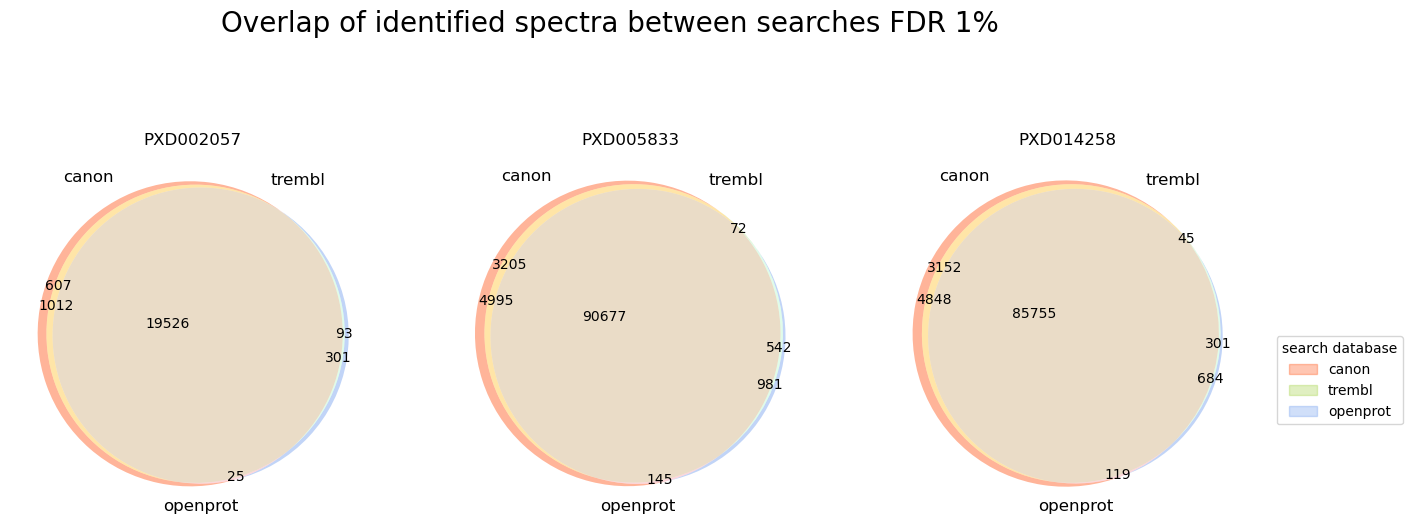

In [25]:
fig, axes = plt.subplots(1, 3, sharey=True,sharex=True, figsize=(16,8))
fig.suptitle('Overlap of identified spectra between searches FDR 1%',size=20, y=0.9);
for i, dataset_name in enumerate(combined_first_datasets):
    dfs=list(combined_first_datasets[dataset_name].values())
    databases=list(combined_first_datasets[dataset_name].keys())
    venn3([set(dfs[0].spectrum_title),set(dfs[1].spectrum_title),set(dfs[2].spectrum_title)], ax=axes[i],
      set_labels=[databases[0],databases[1],databases[2]], set_colors=(project_palette[databases[0]],project_palette[databases[1]],project_palette[databases[2]]))
    axes[i].set_title(f"{dataset_name}")
p=[]
for l,c in project_palette.items():
    p.append(mpatches.Patch(color=c, label=l,alpha=0.3))  
fig.legend(handles=p, title="search database",loc='upper right',bbox_to_anchor=(1, 0.5));

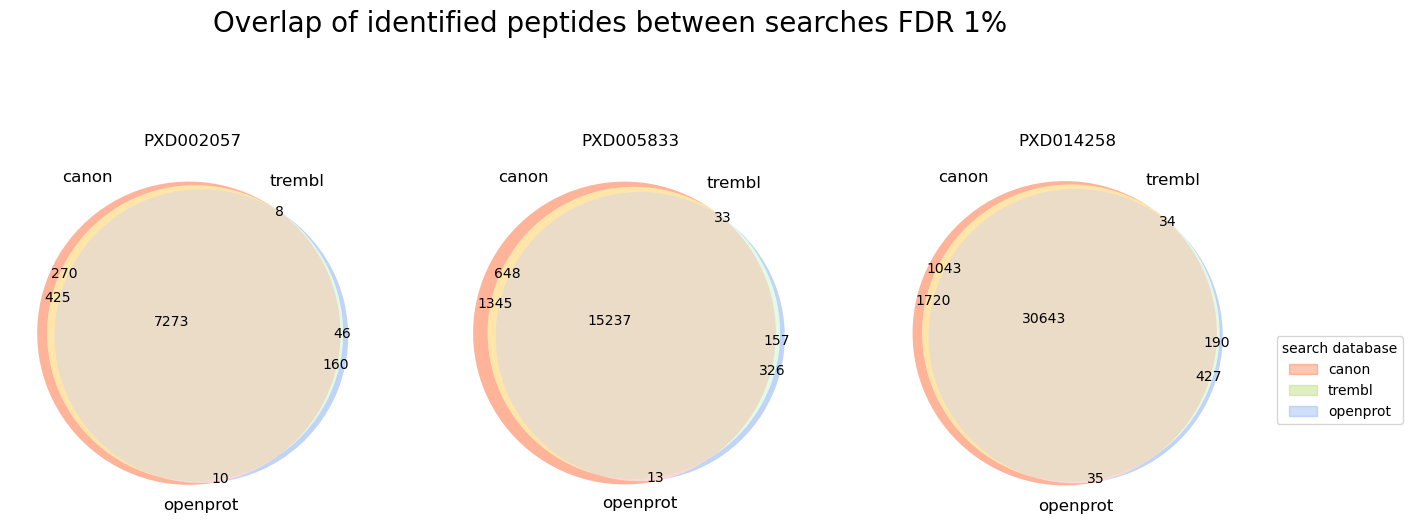

In [26]:
fig, axes = plt.subplots(1, 3, sharey=True,sharex=True, figsize=(16,8))
fig.suptitle('Overlap of identified peptides between searches FDR 1%',size=20, y=0.9);
for i, dataset_name in enumerate(combined_peptides_datasets):
    dfs=list(combined_peptides_datasets[dataset_name].values())
    databases=list(combined_peptides_datasets[dataset_name].keys())
    venn3([set(dfs[0].database_peptide),set(dfs[1].database_peptide),set(dfs[2].database_peptide)], ax=axes[i],
      set_labels=[databases[0],databases[1],databases[2]], set_colors=(project_palette[databases[0]],project_palette[databases[1]],project_palette[databases[2]]))
    axes[i].set_title(f"{dataset_name}")
p=[]
for l,c in project_palette.items():
    p.append(mpatches.Patch(color=c, label=l,alpha=0.3))  
fig.legend(handles=p, title="search database",loc='upper right',bbox_to_anchor=(1, 0.5));

### Peptide & protein class

In [27]:
#on psm level

for dataset_name in combined_first_datasets:
    for database in ["canon","trembl","openprot"]:
        df=combined_first_datasets[dataset_name][database]
        df["peptide_class"]=df.proteins.apply(lambda x: io.classify_peptide_io(x.split("||"),"closed"))
        df["peptide_class"]=df.apply(lambda x: "Decoy" if "decoy" in x["proteins"] else x["peptide_class"],axis=1)
        df["protein_class"]=df.peptide_class.apply(lambda x: io.classify_protbypep_io(x))
        df["protein_class"]=df.apply(lambda x: "Decoy" if "decoy" in x["proteins"] else x["protein_class"],axis=1)
        combined_first_datasets[dataset_name][database]=df

In [28]:
with open('closed_combined_first_datasets.pickle', 'wb') as handle:
    pickle.dump(combined_first_datasets, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('closed_combined_first_datasets.pickle', 'rb') as handle:
    combined_first_datasets=pickle.load(handle)

In [29]:
#on peptide level 

for source in combined_peptides_datasets:
    df=combined_peptides_datasets[source]['openprot']
    df["peptide_class"]=df.proteins.apply(lambda x: io.classify_peptide_io(x.split("||"),"closed"))
    df["peptide_class"]=df.apply(lambda x: "Decoy" if "decoy" in x["proteins"] else x["peptide_class"],axis=1)
    df["protein_class"]=df.peptide_class.apply(lambda x: io.classify_protbypep_io(x))
    df["protein_class"]=df.apply(lambda x: "Decoy" if "decoy" in x["proteins"] else x["protein_class"],axis=1)
    combined_peptides_datasets[source]['openprot']=df

In [30]:
with open('closed_combined_peptides_datasets.pickle', 'wb') as handle:
    pickle.dump(combined_peptides_datasets, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [31]:
#the count of shared and proteotypic peptides

pepsharedproteotyp_df=pd.DataFrame(columns=["pipeline","database","peptide_class","value"])
for database in ["canon","trembl","openprot"]:    
    df=pd.concat([combined_first_datasets[dataset_name][database] for dataset_name in combined_first_datasets])
    ## df=df[(df["database"]=="T")]
    counts=Counter(df.drop_duplicates(["database_peptide"]).peptide_class)
    pepsharedproteotyp_df.loc[len(pepsharedproteotyp_df)]=["ionbot",database,"shared",np.sum([val for key,val in counts.items() if "shared" in key])]
    pepsharedproteotyp_df.loc[len(pepsharedproteotyp_df)]=["ionbot",database,"proteotypic",np.sum([val for key,val in counts.items() if "unique" in key])]

In [32]:
pepsharedproteotyp_df.to_pickle("closed_ionbot_peptype_df.pkl")

#### Save filtered psm and peptide level to share

In [ ]:
#save_hybrid="./oui_discovery_hybrid_filtered_ionbot_closed/"
#
#for dataset_name in combined_first_datasets:
#    for database in combined_first_datasets[dataset_name]:
#        df=combined_first_datasets[dataset_name][database]
#        df.to_csv(f"{save_hybrid}{dataset_name}-{database}-byexperiment-hybrid-filtered-psm.csv",index=False)
#for dataset_name in combined_peptides_datasets:
#    for database in combined_peptides_datasets[dataset_name]:
#        df=combined_peptides_datasets[dataset_name][database]
#        df.to_csv(f"{save_hybrid}{dataset_name}-{database}-byexperiment-hybrid-filtered-pep.csv",index=False)

### Identification rate by search

In [33]:
def get_idrate(mgfFiles, df):    
    IDrate={}
    for file in mgfFiles:
        #print(file.split("."))
        print(file,len(df[df["spectrum_file"].str.contains(file.replace('.RAW.mgf', '.mgf').replace("_merged.mgf",""))]))
        #file=file.replace('.RAW.mgf', '.mgf')
        IDrate[file]=len(df[df["spectrum_file"].str.contains(file.replace('.RAW.mgf', '.mgf').replace("_merged.mgf",""))])/mgfFiles[file]
    return IDrate

In [34]:
idrate_datasets={"PXD002057":0,"PXD005833":0,"PXD014258":0}
for dataset_name in combined_first_datasets:
    idrate_med={"canon":0,"trembl":0,"openprot":0}
    key=[ds for ds in mgfspectraN_datasets if dataset_name in ds][0]
    mgfspectraN=mgfspectraN_datasets[key]
    for database in idrate_med:
        df=combined_first_datasets[dataset_name][database]
        ##dff=df[df["database"]=="T"]
        if dataset_name!="PXD014258":
            idrate_med[database]=list(get_idrate(mgfspectraN, df).values())
        else:
            n= 5 #if dataset_name=="PXD014258" else 5
            #mean neighboring values - fractions
            r=list(get_idrate(mgfspectraN, df).values())
            idrate_med[database]=[np.mean(r[x:x+n]) for x in range(0, len(r), n)]  
    idrate_datasets[dataset_name]=idrate_med

130327_o2_03_hu_C2_2hr.mgf 1962
130327_o2_04_hu_P2_2hr.mgf 4495
130327_o2_06_hu_P3_2hr.mgf 4743
130327_o2_01_hu_C1_2hr.mgf 2587
130327_o2_05_hu_C3_2hr.mgf 1885
130327_o2_02_hu_P1_2hr.mgf 5498
130327_o2_03_hu_C2_2hr.mgf 1783
130327_o2_04_hu_P2_2hr.mgf 4340
130327_o2_06_hu_P3_2hr.mgf 4577
130327_o2_01_hu_C1_2hr.mgf 2402
130327_o2_05_hu_C3_2hr.mgf 1819
130327_o2_02_hu_P1_2hr.mgf 5313
130327_o2_03_hu_C2_2hr.mgf 1800
130327_o2_04_hu_P2_2hr.mgf 4260
130327_o2_06_hu_P3_2hr.mgf 4476
130327_o2_01_hu_C1_2hr.mgf 2448
130327_o2_05_hu_C3_2hr.mgf 1820
130327_o2_02_hu_P1_2hr.mgf 5141
AM10.mgf 6437
AM17.mgf 5493
AM19.mgf 7633
AM18.mgf 5867
AM16.mgf 8440
AM11.mgf 6954
AM7.mgf 5621
AM9.mgf 7410
AM20.mgf 6282
AM12.mgf 7646
AM15.mgf 6326
AM8.mgf 5107
AM14.mgf 7153
AM13.mgf 7109
AM21.mgf 5544
AM10.mgf 6254
AM17.mgf 5252
AM19.mgf 7259
AM18.mgf 5650
AM16.mgf 8181
AM11.mgf 6689
AM7.mgf 5353
AM9.mgf 7115
AM20.mgf 5977
AM12.mgf 7186
AM15.mgf 6022
AM8.mgf 4805
AM14.mgf 6713
AM13.mgf 6784
AM21.mgf 5256
AM10.mgf 6

In [35]:
idrate_datasets_df=pd.DataFrame(columns=["pipline","sample","database","value"])
for dataset in idrate_datasets:
    for database in idrate_datasets[dataset]:
        for i,val in enumerate(idrate_datasets[dataset][database]):
            idrate_datasets_df.loc[len(idrate_datasets_df)]=["ionbot",f"{dataset}_{i}",database,val]
idrate_datasets_df.to_pickle("closed_ionbot_idrate_datasets_df.pkl")

### Identification rate by peptide class

In [36]:
#as tpp does not save spectra by separate file (but merged, input), then add corresponding files n spectra
mgfspectraN_datasets_tpp=mgfspectraN_datasets.copy()
###mgfspectraN_datasets_tpp['PXD005833.v0.11.4']={f'sample_{i}_merged.mgf':mgfspectraN_datasets['PXD005833.v0.11.4'][f'b1369p080_sample_{i}_a.mgf']+mgfspectraN_datasets['PXD005833.v0.11.4'][f'b1369p080_sample_{i}_b.mgf'] for i in ["01","02","03","04","05","06","07","08","09","10","11","12","13","14"]}
tmp={}
for i in ["ESC-HF-Sample-BT474","ESC-HF-SampleHela","ESC-HF-Sample-MCF"]:
    if "BT474" not in i:
        tmp[f"{i}_merged.mgf"]=np.sum([mgfspectraN_datasets['PXD014258.v0.11.4'][f"{i}{j}.RAW.mgf"] for j in range(1,6)])
    else:
        tmp[f"{i}_merged.mgf"]=np.sum([mgfspectraN_datasets['PXD014258.v0.11.4'][f"{i}_{j}.RAW.mgf"] for j in range(1,6)])
mgfspectraN_datasets_tpp['PXD014258.v0.11.4']=tmp
#mgfspectraN_datasets_tpp

In [37]:
del mgfspectraN_datasets_tpp['PXD003594.v0.11.4']

In [38]:
idrate_PEPCL_datasets_df=pd.DataFrame(columns=["pipeline","dataset","peptide_class","value"])
pepcl_order=["unique_to_Noncanon",'shared_in_Noncanon',"unique_to_Canon",'shared_in_Canon','shared_btw_can_noncan']
datasets_index=[f"{dataset_name.replace(".v0.11.4","")}_{i}" for dataset_name,vals in mgfspectraN_datasets_tpp.items() for i in range(len(vals))]
idrate_PEPCL_datasets_df["pipeline"]=["ionbot"]*len(pepcl_order)*len(datasets_index)
idrate_PEPCL_datasets_df["dataset"]=datasets_index*len(pepcl_order)
idrate_PEPCL_datasets_df["peptide_class"]=sorted(pepcl_order*len(datasets_index))

for dataset_name in combined_first_datasets:
    key=[ds for ds in mgfspectraN_datasets if dataset_name in ds][0]
    mgfspectraN=mgfspectraN_datasets_tpp[key]
    database="openprot"
    df=combined_first_datasets[dataset_name][database]
    ##df=df[df.peptide_class!="Decoy"]
    for peptide_class in pepcl_order:        
        values=list(get_idrate(mgfspectraN, df[df.peptide_class==peptide_class]).values())
        idrate_PEPCL_datasets_df.loc[(idrate_PEPCL_datasets_df.dataset.str.contains(dataset_name.replace(".v0.11.4","")))&
            (idrate_PEPCL_datasets_df.peptide_class==peptide_class),"value"]=values
idrate_PEPCL_datasets_df.to_pickle("closed_ionbot_PEPCL_idrate_datasets_df.pkl")

130327_o2_03_hu_C2_2hr.mgf 31
130327_o2_04_hu_P2_2hr.mgf 32
130327_o2_06_hu_P3_2hr.mgf 28
130327_o2_01_hu_C1_2hr.mgf 35
130327_o2_05_hu_C3_2hr.mgf 36
130327_o2_02_hu_P1_2hr.mgf 27
130327_o2_03_hu_C2_2hr.mgf 7
130327_o2_04_hu_P2_2hr.mgf 5
130327_o2_06_hu_P3_2hr.mgf 6
130327_o2_01_hu_C1_2hr.mgf 8
130327_o2_05_hu_C3_2hr.mgf 5
130327_o2_02_hu_P1_2hr.mgf 7
130327_o2_03_hu_C2_2hr.mgf 66
130327_o2_04_hu_P2_2hr.mgf 192
130327_o2_06_hu_P3_2hr.mgf 200
130327_o2_01_hu_C1_2hr.mgf 95
130327_o2_05_hu_C3_2hr.mgf 67
130327_o2_02_hu_P1_2hr.mgf 227
130327_o2_03_hu_C2_2hr.mgf 590
130327_o2_04_hu_P2_2hr.mgf 1543
130327_o2_06_hu_P3_2hr.mgf 1639
130327_o2_01_hu_C1_2hr.mgf 808
130327_o2_05_hu_C3_2hr.mgf 612
130327_o2_02_hu_P1_2hr.mgf 1918
130327_o2_03_hu_C2_2hr.mgf 1106
130327_o2_04_hu_P2_2hr.mgf 2488
130327_o2_06_hu_P3_2hr.mgf 2603
130327_o2_01_hu_C1_2hr.mgf 1502
130327_o2_05_hu_C3_2hr.mgf 1100
130327_o2_02_hu_P1_2hr.mgf 2962
AM10.mgf 26
AM17.mgf 41
AM19.mgf 33
AM18.mgf 36
AM16.mgf 33
AM11.mgf 38
AM7.mgf 31

In [39]:
#how many psms matched peptides of these classes

pipeline="ionbot"
pepcl_n_psm={k:0 for k in ["Canon_unique","Shared","NonCanon_unique"]}
for dataset in combined_first_datasets:
    psm_df=combined_first_datasets[dataset]["openprot"]
    pep_df=combined_peptides_datasets[dataset_name]["openprot"]
    for peptide_class in ["Canon_unique","Shared","NonCanon_unique"]:
        pcl=peptide_classes[peptide_class]
        n=len(psm_df[psm_df.database_peptide.isin(pep_df[pep_df.peptide_class.isin(pcl)].database_peptide.tolist())])
        pepcl_n_psm[peptide_class]+=n

In [40]:
{k:(v/np.sum(list(pepcl_n_psm.values())))*100 for k,v in pepcl_n_psm.items()}

{'Canon_unique': np.float64(36.993674978906334),
 'Shared': np.float64(62.46250869921353),
 'NonCanon_unique': np.float64(0.5438163218801387)}

### Peptides' reproducability

In [41]:
# across all samples

In [42]:
peptides_across_samples_df=pd.DataFrame(columns=["pipeline","peptide","class","value"])
for peptide_class in ["unique_to_Noncanon",'shared_in_Noncanon',"unique_to_Canon",'shared_in_Canon','shared_btw_can_noncan']:
    peptides_across_samples_l=[]
    for dataset_name in combined_peptides_datasets:
        df=combined_peptides_datasets[dataset_name]["openprot"]
        df=df[(df["peptide_class"]==peptide_class)]
        peptides_across_samples_l=peptides_across_samples_l+list(df.drop_duplicates(["database_peptide","spectrum_file"]).database_peptide)
        
    peptides_across_samples_d=Counter(peptides_across_samples_l)
    peptides_across_samples=np.array(list(peptides_across_samples_d.values()))/23 #number of samples
    keys=list(peptides_across_samples_d.keys())
    for i,row in enumerate(peptides_across_samples):
        peptides_across_samples_df.loc[len(peptides_across_samples_df)]=["ionbot",keys[i],peptide_class,row]

In [43]:
peptides_across_samples_df.to_pickle("closed_ionbot_peptides_across_samples_df.pkl")

In [44]:
# across samples of same PXD

In [45]:
peptides_across_samples_PXD_df=pd.DataFrame(columns=["pipeline","peptide","class","value"])
for peptide_class in ["unique_to_Noncanon",'shared_in_Noncanon',"unique_to_Canon",'shared_in_Canon','shared_btw_can_noncan']:
    #peptides_across_samples_l=[]
    for dataset_name in combined_peptides_datasets:
        key=[ds for ds in mgfspectraN_datasets if dataset_name in ds][0]
        mgfspectraN=mgfspectraN_datasets_tpp[key]
        df=combined_peptides_datasets[dataset_name]["openprot"]
        df=df[(df["peptide_class"]==peptide_class)]
        peptides_across_samples_l=list(df.drop_duplicates(["database_peptide","spectrum_file"]).database_peptide)
        
        peptides_across_samples_d=Counter(peptides_across_samples_l)
        peptides_across_samples=np.array(list(peptides_across_samples_d.values()))/len(mgfspectraN) #number of samples
        keys=list(peptides_across_samples_d.keys())
        for i,row in enumerate(peptides_across_samples):
            peptides_across_samples_PXD_df.loc[len(peptides_across_samples_PXD_df)]=["ionbot",keys[i],peptide_class,row]

In [46]:
peptides_across_samples_PXD_df.to_pickle("closed_ionbot_peptides_across_samples_PXD_df.pkl")

In [47]:
#count by PXD

tmp_all={}
peptides_across_samples_PEP_df=pd.DataFrame(columns=["pipeline","PXD","peptide_class","value","count"])
for dataset_name in combined_first_datasets:
    tmp_all[dataset_name]={}
    for peptide_class in ["unique_to_Noncanon",'shared_in_Noncanon',"unique_to_Canon",'shared_in_Canon','shared_btw_can_noncan']:#("Canon_unique", "NonCanon_unique", "Shared"):
        df=combined_first_datasets[dataset_name]["openprot"]
        df=df[(df["database"]=="T")&(df["peptide_class"]==peptide_class)]
        peptides_across_samples_l=list(df.database_peptide.unique())
        tmp=pd.DataFrame(index=peptides_across_samples_l,columns=df.spectrum_file.unique())
        for spectrum_file in tmp.columns:
            tmp[spectrum_file]=[pep in df[df.spectrum_file==spectrum_file].database_peptide.unique() for pep in tmp.index]
        tmp["count"]=tmp.apply(lambda x: Counter(x)[True] ,axis=1)
        peptides_across_samples_PEP_df.loc[len(peptides_across_samples_PEP_df)]=["ionbot",dataset_name,peptide_class,1,len(tmp[tmp["count"]==1])]
        peptides_across_samples_PEP_df.loc[len(peptides_across_samples_PEP_df)]=["ionbot",dataset_name,peptide_class,2,len(tmp[tmp["count"]==2])]
        peptides_across_samples_PEP_df.loc[len(peptides_across_samples_PEP_df)]=["ionbot",dataset_name,peptide_class,3,len(tmp[tmp["count"]==3])]
        peptides_across_samples_PEP_df.loc[len(peptides_across_samples_PEP_df)]=["ionbot",dataset_name,peptide_class,4,len(tmp[tmp["count"]>3])]

In [ ]:
#all

#add all
for peptide_class in ["unique_to_Noncanon",'shared_in_Noncanon',"unique_to_Canon",'shared_in_Canon','shared_btw_can_noncan']:
    df=pd.concat([combined_first_datasets[dataset_name]["openprot"] for dataset_name in combined_first_datasets])
    df=df[(df["database"]=="T")&(df["peptide_class"]==peptide_class)]
    peptides_across_samples_l=list(df.database_peptide.unique())
    tmp=pd.DataFrame(index=peptides_across_samples_l,columns=df.spectrum_file.unique())
    for spectrum_file in tmp.columns:
        tmp[spectrum_file]=[pep in df[df.spectrum_file==spectrum_file].database_peptide.unique() for pep in tmp.index]
    tmp["count"]=tmp.apply(lambda x: Counter(x)[True] ,axis=1)
    peptides_across_samples_PEP_df.loc[len(peptides_across_samples_PEP_df)]=["ionbot","all",peptide_class,1,len(tmp[tmp["count"]==1])]
    peptides_across_samples_PEP_df.loc[len(peptides_across_samples_PEP_df)]=["ionbot","all",peptide_class,2,len(tmp[tmp["count"]==2])]
    peptides_across_samples_PEP_df.loc[len(peptides_across_samples_PEP_df)]=["ionbot","all",peptide_class,3,len(tmp[tmp["count"]==3])]
    peptides_across_samples_PEP_df.loc[len(peptides_across_samples_PEP_df)]=["ionbot","all",peptide_class,4,len(tmp[tmp["count"]>3])]

In [ ]:
peptides_across_samples_PEP_df.to_pickle("closed_ionbot_peptides_across_samples_PEP_df.pkl")

### Number of PSMs per peptide class

In [ ]:
#here I count same peptide in diff samples separatly
pepcl_psm_frq={"peptide":[],"peptide_class":[],"psm_num":[]}
for peptide_class in ["unique_to_Noncanon",'shared_in_Noncanon',"unique_to_Canon",'shared_in_Canon','shared_btw_can_noncan']: #("Canon_unique", "NonCanon_unique", "Shared")
    peps_dst=[]
    for dataset_name in combined_peptides_datasets:
        df=combined_peptides_datasets[dataset_name]["openprot"]
        df=df[(df["peptide_class"]==peptide_class)]
        peps_dst=peps_dst+list(df.database_peptide)
    psm_dfs=pd.concat([subdict["openprot"] for dataset,subdict in combined_first_datasets.items()])
    peps_count=Counter(psm_dfs[psm_dfs.database_peptide.isin(peps_dst)].database_peptide)
    peps_count_v=list(list(peps_count.values()))
    pepcl_psm_frq["peptide"]=pepcl_psm_frq["peptide"]+list(list(peps_count.keys()))
    pepcl_psm_frq["peptide_class"]=pepcl_psm_frq["peptide_class"]+[peptide_class]*len(peps_count_v)
    pepcl_psm_frq["psm_num"]=pepcl_psm_frq["psm_num"]+[p for p in peps_count_v] #np.log(p)
pepcl_psm_frq=pd.DataFrame(pepcl_psm_frq)
pepcl_psm_frq["pipeline"]="ionbot"
pepcl_psm_frq["bin"]=np.nan
for bin,group in enumerate([[1],[2],list(range(3,5+1)),list(range(5,10+1)),list(range(10,15+1)),list(range(15,20+1))]):
    pepcl_psm_frq.loc[pepcl_psm_frq.psm_num.isin(group),"bin"]=bin

In [ ]:
pepcl_psm_frq.to_pickle("closed_ionbot_pepcl_psm_frq.pkl")

In [ ]:
########----------wait-new-inference

### Proteins

In [ ]:
combined_proteins_ocacam=pd.DataFrame()
for dataset_name in combined_peptides_datasets:
    databases=["canon","trembl","openprot"]
    for database in databases:
        df=io.combine_ionbot(working_folder, f"{dataset_name}-closed", f"-{database}","sample_protein_groups_Occam.csv")
        df.reset_index(inplace=True,drop=True)
        combined_proteins_ocacam=pd.concat([combined_proteins_ocacam,df])
combined_proteins_ocacam.reset_index(inplace=True,drop=True)

In [ ]:
#fix spectrum file
fix2057tr={'130327_o2_06_trembl': '130327_o2_06_hu_P3_2hr.mgf',
  '130327_o2_05_trembl': '130327_o2_05_hu_C3_2hr.mgf',
  '130327_o2_03_trembl': '130327_o2_03_hu_C2_2hr.mgf',
  '130327_o2_01_trembl': '130327_o2_01_hu_C1_2hr.mgf',
  '130327_o2_02_trembl': '130327_o2_02_hu_P1_2hr.mgf',
  '130327_o2_04_trembl': '130327_o2_04_hu_P2_2hr.mgf'}
a=pd.DataFrame()
for (dataset,database,spectrum_file),group in combined_proteins_ocacam.groupby(["PXD","searchDB","spectrum_file"]):
    if dataset=="PXD002057" and database=="trembl":
        for experiment,group_2 in group.groupby("experiment"):
            group_2["spectrum_file"]=fix2057tr[experiment]
            a=pd.concat([a,group_2])
    else:
        group["spectrum_file"]=fix_spectrum_file[dataset.replace("-closed","")][database][spectrum_file]
        a=pd.concat([a,group])
combined_proteins_ocacam=a

In [ ]:
combined_first_mega=pd.concat([combined_first_datasets[dataset]["openprot"] for dataset in combined_first_datasets.keys()])

In [ ]:
#filtered?
combined_proteins_ocacam['q-value'].max()

In [ ]:
#filter by qval
combined_proteins_ocacam=combined_proteins_ocacam[combined_proteins_ocacam['q-value']<0.01]

In [ ]:
#drop decoys
combined_proteins_ocacam=combined_proteins_ocacam[combined_proteins_ocacam.database!="D"]

In [ ]:
#classify: 1 protein/group

combined_proteins_ocacam["level"]=np.nan
for (PXD, spectrum_file, database ), group in combined_proteins_ocacam.groupby(['PXD','spectrum_file','searchDB',]):
    df=combined_first_datasets[PXD.replace("-closed","")][database]
    df=df[df.spectrum_file==spectrum_file]
    combined_proteins_ocacam.loc[(combined_proteins_ocacam.PXD==PXD)&(
        combined_proteins_ocacam.spectrum_file==spectrum_file)&(
        combined_proteins_ocacam.searchDB==database),"level"]=group.proteins.apply(lambda x: "Group" if "," in x else "Singleton")
    #group.proteins.apply(lambda x: "Singleton" if any( not "||" in psm for psm in df[df.proteins.str.contains(x)].proteins.value_counts().index) else "Group")
   

In [ ]:
combined_proteins_ocacam[["searchDB","level"]].value_counts()

In [ ]:
combined_proteins_ocacam.to_pickle("closed_ionbot_combined_proteins_ocacam.pickle")

In [ ]:
combined_proteins_ocacam=pd.read_pickle("closed_ionbot_combined_proteins_ocacam.pickle")

In [ ]:
def get_nonc_prots(pep_df,mode):
    return list(set([io.extract_accession(p, mode) for p in pep_df[pep_df.peptide_class.isin(["unique_to_Noncanon"])].proteins]))

In [ ]:
combined_proteins_ocacam_newop=combined_proteins_ocacam.copy(deep=True)
#filter out noncanonical proteins from combined_proteins_ocacam
for (dataset,spectrum_file),group in combined_proteins_ocacam[combined_proteins_ocacam.searchDB=="openprot"].groupby(["PXD","spectrum_file"]):
    #print(spectrum_file)
    spectrum_file_mod=spectrum_file.rstrip(".gzip").replace("-openprot","").replace("_openprot","")
    drop_op=group[(group.FDRGroup=="NonCanon")].index
    #combined_proteins_ocacam_newop.drop(drop_op,axis=0,inplace=True)
    pep_df=combined_peptides_datasets[dataset.replace("-closed","")]["openprot"]
    pep_df=pep_df[pep_df.peptide_class!="Decoy"]
    op_ncprot=get_nonc_prots(pep_df.loc[pep_df.spectrum_file.str.contains(spectrum_file_mod)],"closed")
    tmp=pd.DataFrame({col:(op_ncprot if col=="proteins" 
                           else [dataset]*len(op_ncprot) if col=="PXD" 
                           else [spectrum_file]*len(op_ncprot) if col=="experiment"
                           else ["NonCanon"]*len(op_ncprot) if col=="FDRGroup"
                           else ["openprot"]*len(op_ncprot) if col=="searchDB"
                           else ["Singleton"]*len(op_ncprot) if col=="level"
                           else ["T"]*len(op_ncprot) if col=="database"
                           else [np.nan]*len(op_ncprot)) for col in group.columns})
    print(spectrum_file,len(tmp))
    combined_proteins_ocacam_newop=pd.concat([combined_proteins_ocacam_newop,tmp])
combined_proteins_ocacam_newop.reset_index(drop=True,inplace=True)

In [ ]:
#drop previous non-canonical proteins

combined_proteins_ocacam_newop=combined_proteins_ocacam_newop[~((combined_proteins_ocacam_newop.FDRGroup=="NonCanon")&(combined_proteins_ocacam_newop.psm_score.isna()==False))]

In [ ]:
#also drop non-canonical proteins from Groups, because we concider them non-identified on protein level

for i,row in combined_proteins_ocacam_newop.iterrows():
    if row["level"]=="Group":
        nc=[ prot.startswith(("IP_","II_")) for prot in row["proteins"].split(",")]
        if all(nc): #delet nc groups
            combined_proteins_ocacam_newop.drop(i,axis=0,inplace=True)
        else:
            combined_proteins_ocacam_newop.loc[i,"proteins"]=",".join([prot for prot,isnc in zip(row["proteins"].split(","),nc) if not isnc])

In [ ]:
# Number of proteins identified with ionbot by search

bysearch_proteins=pd.DataFrame(columns=["pipeline","database","group","value"])
for database,group in combined_proteins_ocacam_newop.groupby(["searchDB"]):
    group_sing=group[group.level=="Singleton"]
    group_uplim=group[group.level=="Group"]
    singletons=set(group_sing.proteins.tolist())
    uplim=set([p for g in group_uplim.proteins.tolist() for p in g.split(",")])
    print(database,len(singletons),len(uplim-singletons))
    bysearch_proteins.loc[len(bysearch_proteins)]=["ionbot",database[0],"singletons",len(singletons)]
    bysearch_proteins.loc[len(bysearch_proteins)]=["ionbot",database[0],"indistinguishable proteins",len(uplim-singletons)]
bysearch_proteins.to_pickle("closed_ionbot_bysearch_proteins.pkl")

### Proteins reproducability

In [ ]:
#across all samples 

prot_reproduce_ionbot=pd.DataFrame(columns=["pipeline","database","level","protein","frequency"]);
for database, group in combined_proteins_ocacam_newop.groupby(["searchDB"]):
    group.drop_duplicates(["proteins","experiment"],inplace=True)
    group_sig=group[group.level=="Singleton"]    
    counts_sig=group_sig.proteins.value_counts().to_dict()
    frq_sig={p:n/24 for p,n in counts_sig.items()}
    prot_sing=set(counts_sig.keys())
    #it treaky, because in different samples protein can be in group of several entries
    group_uplim=group[group.level=="Group"]
    prot_uplim_exp={file:set([p for i,row in sub.iterrows() for p in row["proteins"].split(",")]) for file,sub in group_uplim.groupby("experiment")}
    #subtract singeltons
    prot_uplim_corr={file:list(prots-set(group_sig[group_sig.experiment==file].proteins.tolist())) for file,prots in prot_uplim_exp.items()}      
    #unlist
    counts_uplim=Counter([el for l in prot_uplim_corr.values() for el in l])
    frq_uplim={p:n/24 for p,n in counts_uplim.items()}
    L=len(frq_sig)+len(frq_uplim)
    tmp={"pipeline":["ionbot"]*L,"database":[database[0]]*L,"level":["razor"]*len(frq_sig)+["from group"]*len(frq_uplim),
         "protein":list(frq_sig.keys())+list(frq_uplim.keys()),"frequency":list(frq_sig.values())+list(frq_uplim.values())
        }
    prot_reproduce_ionbot=pd.concat([prot_reproduce_ionbot,pd.DataFrame(tmp)])

In [ ]:
prot_reproduce_ionbot.to_pickle("closed_ionbot_prot_reproduce.pkl")

In [ ]:
a=prot_reproduce_ionbot[(prot_reproduce_ionbot.database=="openprot")&(prot_reproduce_ionbot.protein.apply(lambda x: x.startswith("II_") or x.startswith("IP_")))]
a.frequency.mean()

In [ ]:
#across samples of same PXD

prot_reproduce_PXD_ionbot=pd.DataFrame(columns=["pipeline","database","level","protein","frequency"]);
for (database, PXD), group_pxd in combined_proteins_ocacam_newop.groupby(["searchDB","PXD"]):
    group_pxd.drop_duplicates(["proteins","experiment"],inplace=True)
    group_sig=group_pxd[group_pxd.level=="Singleton"]    
    counts_sig=group_sig.proteins.value_counts().to_dict()
    key=[ds for ds in mgfspectraN_datasets if dataset_name in ds][0]
    mgfspectraN=mgfspectraN_datasets_tpp[key]
    frq_sig={p:n/len(mgfspectraN) for p,n in counts_sig.items()}
    prot_sing=set(counts_sig.keys())
    #it treaky, because in different samples protein can be in group of several entries
    group_uplim=group_pxd[group_pxd.level=="Group"]
    prot_uplim_exp={file:set([p for i,row in sub.iterrows() for p in row["proteins"].split(",")]) for file,sub in group_uplim.groupby("experiment")}
    #subtract singeltons
    prot_uplim_corr={file:list(prots-set(group_sig[group_sig.experiment==file].proteins.tolist())) for file,prots in prot_uplim_exp.items()}      
    #unlist
    counts_uplim=Counter([el for l in prot_uplim_corr.values() for el in l])
    frq_uplim={p:n/len(mgfspectraN) for p,n in counts_uplim.items()}
    L=len(frq_sig)+len(frq_uplim)
    tmp={"pipeline":["ionbot"]*L,"database":[database]*L,"level":["razor"]*len(frq_sig)+["from group"]*len(frq_uplim),
         "protein":list(frq_sig.keys())+list(frq_uplim.keys()),"frequency":list(frq_sig.values())+list(frq_uplim.values())
        }
    prot_reproduce_PXD_ionbot=pd.concat([prot_reproduce_PXD_ionbot,pd.DataFrame(tmp)])

In [ ]:
prot_reproduce_PXD_ionbot.to_pickle("closed_ionbot_prot_reproduce_PXD.pkl")

In [ ]:
#across samples of same PXD, counts

values=list(range(1,4))
prot_reproduce_PXD_ionbot_counts=pd.DataFrame(columns=["pipeline","PXD","database","level","value","count"])
for (database, PXD), group_pxd in combined_proteins_ocacam_newop.groupby(["searchDB","PXD"]):
    group_pxd.drop_duplicates(["proteins","experiment"],inplace=True)
    group_sig=group_pxd[group_pxd.level=="Singleton"]    
    counts_sig=group_sig.proteins.value_counts().to_dict()
    key=[ds for ds in mgfspectraN_datasets if dataset_name in ds][0]
    mgfspectraN=mgfspectraN_datasets_tpp[key]
    frq_sig={p:n for p,n in counts_sig.items()}
    prot_sing=set(counts_sig.keys())
    #it treaky, because in different samples protein can be in group of several entries
    group_uplim=group_pxd[group_pxd.level=="Group"]
    prot_uplim_exp={file:set([p for i,row in sub.iterrows() for p in row["proteins"].split(",")]) for file,sub in group_uplim.groupby("experiment")}
    #subtract singeltons
    prot_uplim_corr={file:list(prots-set(group_sig[group_sig.experiment==file].proteins.tolist())) for file,prots in prot_uplim_exp.items()}      
    #unlist
    counts_uplim=Counter([el for l in prot_uplim_corr.values() for el in l])
    frq_uplim={p:n for p,n in counts_uplim.items()}
    ###L=len(frq_sig)+len(frq_uplim)
    value_counts_sig=Counter(list(frq_sig.values()))
    value_counts_uplim=Counter(list(frq_uplim.values()))
    L=len(values)*2
    tmp={"pipeline":["ionbot"]*L,"PXD":[PXD.replace("-closed","")]*L,"database":[database]*L,"level":["razor"]*len(values)+["from group"]*len(values),"value":values*2,
         "count":[value_counts_sig[i] if i<3 else np.sum([v for k,v in value_counts_sig.items() if k>=3]) for i in values]+[value_counts_uplim[i] if i<3 else np.sum([v for k,v in value_counts_uplim.items() if k>=3]) for i in values]
        }
    #break
    prot_reproduce_PXD_ionbot_counts=pd.concat([prot_reproduce_PXD_ionbot_counts,pd.DataFrame(tmp)])

In [ ]:
#add all

values=list(range(1,4))
for (database,level),group in prot_reproduce_ionbot.groupby(["database","level"]):
    counts={k*24:v for k,v in dict(group.frequency.value_counts()).items()}
    L=len(values)
    tmp={"pipeline":["ionbot"]*L,"PXD":["all"]*L,"database":[database]*L,"level":[level]*len(values),"value":values,
         "count":[0 if i not in counts.keys() else counts[i] if i<3 else np.sum([v for k,v in counts.items() if k>=3]) for i in values]
        }
    prot_reproduce_PXD_ionbot_counts=pd.concat([prot_reproduce_PXD_ionbot_counts,pd.DataFrame(tmp)])

In [ ]:
prot_reproduce_PXD_ionbot_counts.to_pickle("closed_ionbot_protrepr_PXD_counts.pkl")

In [ ]:
#across samples of same PXD, counts BY PROTEIN CLASS, singeltons

values=list(range(1,4))
prot_reproduce_PXD_ionbot_protcl_counts=pd.DataFrame(columns=["pipeline","PXD","FDRGroup","level","value","count"])
for (FDRGroup, PXD), group_pxd in combined_proteins_ocacam_newop.groupby(["FDRGroup","PXD"]):
    group_pxd.drop_duplicates(["proteins","experiment"],inplace=True)
    group_sig=group_pxd[group_pxd.level=="Singleton"]    
    counts_sig=group_sig.proteins.value_counts().to_dict()
    prot_sing=Counter(counts_sig.values())
    L=len(values)
    tmp={"pipeline":["ionbot"]*L,"PXD":[PXD.replace("-closed","")]*L,"FDRGroup":[FDRGroup]*L,"level":["razor"]*L,"value":values,
         "count":[prot_sing[i] if i<3 else np.sum([v for k,v in prot_sing.items() if k>=3]) for i in values]
        }
    prot_reproduce_PXD_ionbot_protcl_counts=pd.concat([prot_reproduce_PXD_ionbot_protcl_counts,pd.DataFrame(tmp)])

In [ ]:
#add all

values=list(range(1,4))
for FDRGroup, group_pxd in combined_proteins_ocacam_newop.groupby(["FDRGroup"]):
    group_pxd.drop_duplicates(["proteins","experiment"],inplace=True)
    group_sig=group_pxd[group_pxd.level=="Singleton"]    
    counts_sig=group_sig.proteins.value_counts().to_dict()
    prot_sing=Counter(counts_sig.values())
    L=len(values)
    tmp={"pipeline":["ionbot"]*L,"PXD":["all"]*L,"FDRGroup":[FDRGroup[0]]*L,"level":["razor"]*L,"value":values,
         "count":[prot_sing[i] if i<3 else np.sum([v for k,v in prot_sing.items() if k>=3]) for i in values]
        }
    prot_reproduce_PXD_ionbot_protcl_counts=pd.concat([prot_reproduce_PXD_ionbot_protcl_counts,pd.DataFrame(tmp)])

In [ ]:
prot_reproduce_PXD_ionbot_protcl_counts.to_pickle("closed_prot_reproduce_PXD_ionbot_protcl_counts.pkl")

### Number of proteins per protein class

In [ ]:
byprotclass_proteins=pd.DataFrame(columns=["pipeline","search","protein_class","group","value"])
for (search,protein_class),group in combined_proteins_ocacam_newop.groupby(["searchDB","FDRGroup"]):
    group_sing=group[group.level=="Singleton"]
    group_uplim=group[group.level=="Group"]
    singletons=set(group_sing.proteins.tolist())
    uplim=set([p for g in group_uplim.proteins.tolist() for p in g.split(",")])
    byprotclass_proteins.loc[len(byprotclass_proteins)]=["ionbot",search,protein_class,"singletons",len(singletons)]
    byprotclass_proteins.loc[len(byprotclass_proteins)]=["ionbot",search,protein_class,"indistinguishable proteins",len(uplim-singletons)]
byprotclass_proteins.to_pickle("closed_ionbot_byprotclass_proteins.pkl")

### Number of peptides & PSMs per protein per protein class

In [ ]:
peptide_df=pd.concat([combined_peptides_datasets[dataset_name]["openprot"] for dataset_name in combined_peptides_datasets])
peptide_df['proteins_expand'] = peptide_df.proteins.apply(lambda x: [io.extract_accession(p, "closed") for p in x.split("||")])
peptide_df = peptide_df.explode('proteins_expand').reset_index(drop=True)
#peptide_df.to_pickle("closed_protein_expended_combined_peptides.pkl")
psm_df=pd.concat([combined_first_datasets[dataset_name]["openprot"] for dataset_name in combined_first_datasets])
psm_df['proteins_expand'] = psm_df.proteins.apply(lambda x: [io.extract_accession(x, "closed") for p in x.split("||")])
psm_df = psm_df.explode('proteins_expand').reset_index(drop=True)
#psm_df.to_pickle("closed_protein_expended_combined_first.pkl")

In [ ]:
#peptide_df.to_pickle("closed_protein_expended_combined_peptides.pkl")
#psm_df.to_pickle("closed_protein_expended_combined_first.pkl")

In [ ]:
#peptide_df=pd.read_pickle("closed_protein_expended_combined_peptides.pkl")
#peptide_df.drop_duplicates(['database_peptide','proteins_expand'],inplace=True)

In [ ]:
#psm_df=pd.read_pickle("closed_protein_expended_combined_first.pkl")

In [ ]:
#proteins_pep_df=pd.DataFrame(columns=["proteins_","protein_class"])#,"Unique","Shared"])
#proteins_psm_df=pd.DataFrame(columns=["proteins_","protein_class"])#,"Unique","Shared"])
#
#for protein_class,group in combined_proteins_ocacam_newop[combined_proteins_ocacam_newop.searchDB=="openprot"].groupby(["FDRGroup"]):
#    print(protein_class)
#    if protein_class[0]=="Canon": pep_class_pref="Canon"                
#    elif protein_class[0]=="NonCanon": pep_class_pref="Noncanon"
#    proteins=group[group.level=="Singleton"].proteins.tolist()+[p for g in group[group.level=="Group"].proteins.tolist() for p in g.split(",")]
#    print("add prots",len(list(set(proteins))))
#
#    cl_unique_pep_df_counts=io.get_frompepdf_pepcounts_io(peptide_df,f"unique_to_{pep_class_pref}",proteins)
#    cl_shin_pep_df_counts=io.get_frompepdf_pepcounts_io(peptide_df,f"shared_in_{pep_class_pref}",proteins)
#    cl_shared_pep_df_counts=io.get_frompepdf_pepcounts_io(peptide_df,"shared_btw_can_noncan",proteins)
#    print("add pep counts",len(cl_shared_pep_df_counts))
#    add_pr=set(proteins)
#    prot_pep_df=pd.DataFrame({"proteins_":list(add_pr),"protein_class":[protein_class[0]]*len(add_pr),
#                 "unique_to_class":list(cl_unique_pep_df_counts.values()),
#                "shared_in_class":list(cl_shin_pep_df_counts.values()),
#                 "shared_btw_classes":list(cl_shared_pep_df_counts.values())})
#    
#    proteins_pep_df=pd.concat([proteins_pep_df,prot_pep_df])
#    print(proteins_pep_df.head())
#    #psm    
#    cl_unique_psm_df_counts=io.get_frompsmdf_psmcounts_io(peptide_df,psm_df,f"unique_to_{pep_class_pref}",proteins)
#    cl_shin_psm_df_counts=io.get_frompsmdf_psmcounts_io(peptide_df,psm_df,f"shared_in_{pep_class_pref}",proteins)
#    cl_shared_psm_df_counts=io.get_frompsmdf_psmcounts_io(peptide_df,psm_df,"shared_btw_can_noncan",proteins)
#    prot_psm_df=pd.DataFrame({"proteins_":list(add_pr),"protein_class":[protein_class[0]]*len(add_pr),
#                 "unique_to_class":list(cl_unique_psm_df_counts.values()),
#                "shared_in_class":list(cl_shin_psm_df_counts.values()),
#                 "shared_btw_classes":list(cl_shared_psm_df_counts.values())})
#    proteins_psm_df=pd.concat([proteins_psm_df,prot_psm_df])

In [ ]:
def classify_protein_byprotname_io(x):
    if 'decoy' in x:
        return 'Decoy'

    if 'CONTAMINANT' in x or 'contaminant' in x:
        return 'Contam'
    elif x.startswith('II_') or x.startswith('IP_'):
        return 'NonCanon'
    else:
        return 'Canon'

In [ ]:
#concatinate all datasets

combined_first_mega=pd.concat([combined_first_datasets[dataset]["openprot"] for dataset in combined_first_datasets.keys()])
combined_peptides_mega=pd.concat([combined_peptides_datasets[dataset]["openprot"] for dataset in combined_peptides_datasets.keys()])

In [ ]:
#get all proteins

proteins_all=set(combined_proteins_ocacam_newop[(combined_proteins_ocacam_newop.searchDB=="openprot")&
                 (combined_proteins_ocacam_newop.level=="Singleton")].proteins.tolist()+
                 [p for g in combined_proteins_ocacam_newop[(combined_proteins_ocacam_newop.searchDB=="openprot")&
                  (combined_proteins_ocacam_newop.level=="Group")].proteins.tolist() for p in g.split(",")])

#creat the output tables

cols=["proteins","protein_class","unique_to_class","shared_in_class","shared_btw_classes"]
proteins_pep_counts=pd.DataFrame(columns=cols)
proteins_psm_counts=pd.DataFrame(columns=cols)

proteins_pep_counts["proteins"]=list(proteins_all)
proteins_psm_counts["proteins"]=list(proteins_all)

In [ ]:
#caution, runs for a long time
#count psms and peptides per protein (datasets merged)

fill_cols=["protein_class","unique_to_class","shared_in_class","shared_btw_classes"]
for protein in proteins_all:
    #print(protein)
    protein_class=io.classify_protein_byprotname_io(protein)       
    if protein_class=="Canon": pep_class_pref="Canon"                
    elif protein_class=="NonCanon": pep_class_pref="Noncanon"
    found_sp=combined_first_mega[combined_first_mega.proteins.str.contains(protein)]
    sp_class=Counter(found_sp.peptide_class.tolist())
    pep_class=Counter(found_sp.drop_duplicates("database_peptide").peptide_class.tolist())
    #fill table
    proteins_psm_counts.loc[proteins_psm_counts.proteins==protein,fill_cols]=[protein_class,sp_class[f"unique_to_{pep_class_pref}"],
                                                                              sp_class[f"shared_in_{pep_class_pref}"],sp_class["shared_btw_can_noncan"]]

    proteins_pep_counts.loc[proteins_pep_counts.proteins==protein,fill_cols]=[protein_class,pep_class[f"unique_to_{pep_class_pref}"],
                                                                              pep_class[f"shared_in_{pep_class_pref}"],pep_class["shared_btw_can_noncan"]]
    #break

In [ ]:
proteins_pep_counts.to_pickle("closed_ionbot_proteins_pep_df.pkl")
proteins_psm_counts.to_pickle("closed_ionbot_proteins_psm_df.pkl")

In [ ]:
#these are identified from PSMs of lower quality

In [ ]:
proteins_pep_counts["tot"]=proteins_pep_counts.apply(lambda x: int(np.sum(x[["unique_to_class","shared_in_class","shared_btw_classes"]])),axis=1)
proteins_psm_counts["tot"]=proteins_psm_counts.apply(lambda x: int(np.sum(x[["unique_to_class","shared_in_class","shared_btw_classes"]])),axis=1)

In [ ]:
len(proteins_pep_counts[proteins_pep_counts.tot==0]),len(proteins_pep_counts)

In [ ]:
len(proteins_psm_counts[proteins_psm_counts.tot==0]),len(proteins_psm_counts)

In [ ]:
#fill the "filtered out" proteins. Use psm level

proteins_pep_counts["isFiltered"]=proteins_psm_counts.tot==0
proteins_psm_counts["isFiltered"]=proteins_psm_counts.tot==0

In [ ]:
proteins_pep_counts["tot_class"]=proteins_pep_counts.apply(lambda x: int(np.sum(x[["unique_to_class","shared_in_class"]])),axis=1)
proteins_psm_counts["tot_class"]=proteins_psm_counts.apply(lambda x: int(np.sum(x[["unique_to_class","shared_in_class"]])),axis=1)

In [ ]:
proteins_pep_counts[(proteins_pep_counts.protein_class=="NonCanon")&(proteins_pep_counts.tot_class!=0)].tot_class.mean()

In [ ]:
proteins_psm_counts[(proteins_psm_counts.protein_class=="NonCanon")&(proteins_psm_counts.tot_class!=0)].tot_class.mean()

In [ ]:
a=proteins_pep_counts[(proteins_pep_counts.protein_class=="NonCanon")&(proteins_pep_counts.tot_class!=0)]
len(a[(a.unique_to_class>1)])/len(a)

In [ ]:
a=proteins_psm_counts[(proteins_psm_counts.protein_class=="NonCanon")&(proteins_psm_counts.tot_class!=0)]
len(a[(a.unique_to_class>1)])/len(a)

In [ ]:
#####

### Proteotypic peptides coverage

In [ ]:
all_peptide_sequences=pickle.load(open('all_peptide_sequences_OP_7302.pkl', 'rb'))
is_unique=pickle.load(open('is_unique_OP_7302.pkl', 'rb'))

In [ ]:
#get positions of in silico digestion unique peptides
#leave only proteins that were identified
proteins_op=combined_proteins_ocacam_newop[combined_proteins_ocacam_newop.level=="Singleton"].proteins.tolist()+[p for g in combined_proteins_ocacam_newop[combined_proteins_ocacam_newop.level=="Group"].proteins.tolist() for p in g.split(",")]
#filterout proteins with shared peptide ["Canon_unique","NonCanon_unique"]
peptide_df_identunique=peptide_df[(peptide_df.peptide_class.isin(peptide_classes["Canon_unique"]+peptide_classes["NonCanon_unique"]))&(peptide_df.proteins_expand.isin(set(proteins_op)))]

In [ ]:
peptide_df_identunique["peptide_position"]=peptide_df_identunique["proteins"].apply(lambda x: x.split("((")[1].split("))")[0].split("-"))

In [ ]:
#correct for python indexing
peptide_df_identunique["peptide_position"]=peptide_df_identunique["peptide_position"].apply(lambda x: (int(x[0])-1,int(x[1])-2))

In [ ]:
#filterout non-unique peptides
peptide_df_identunique["shared"]=peptide_df_identunique["proteins"].apply(lambda x: "||" in x )

In [ ]:
peptide_df_identunique=peptide_df_identunique[peptide_df_identunique.shared==False]

In [ ]:
all_peptide_sequences_identunique={}
all_peptide_sequences_prot=[p.split("|")[1] for p in all_peptide_sequences.keys()]
for prot_i in set(peptide_df_identunique.proteins_expand.tolist()):
    prot=f'op|{prot_i}|TX=9606'
    peps=all_peptide_sequences[prot]
    peps_unique=[is_unique[p]  for p in peps] #if p in peptide_df_identunique[peptide_df_identunique.proteins_x_expand==prot_i].database_peptide.tolist()
    peps_unique=np.array(peps)[peps_unique]
    all_peptide_sequences_identunique[prot_i]=peps_unique

In [ ]:
all_peptide_sequences_identunique_pos={}
for prot_i,uniquepeps in all_peptide_sequences_identunique.items():
    group=pd.DataFrame({"database_peptide":list(uniquepeps),"peptide_position":[np.nan]*len(uniquepeps)})
    prot_seq=str(OPfasta[f'op|{prot_i}|TX=9606'].seq)
    uniquepeps_pos=[]
    for pep in uniquepeps:
        #print(pep)
        pos=hpp.get_pep_positions(prot_seq,pep)
        if len(pos)>1: pos=[pos[0]]
        uniquepeps_pos=uniquepeps_pos+pos
    group["peptide_position"]=uniquepeps_pos
    all_peptide_sequences_identunique_pos[prot_i]=group

In [ ]:
#get the number of aninoasids coverged with unique peptides
all_peptide_sequences_identunique_pos_wident={}
for prot_i,uniquepeps_df in all_peptide_sequences_identunique_pos.items():
    ident_df=peptide_df_identunique.groupby("proteins_expand").get_group(prot_i)
    all_peptide_sequences_identunique_pos_wident[prot_i]=uniquepeps_df.merge(ident_df[["database_peptide","peptide_position"]],how="outer",on="database_peptide")

In [ ]:
unique_peptide_aa_coverege={}
for prot_i,uniquepeps_df in all_peptide_sequences_identunique_pos_wident.items():
    #if peptide not known by in situ, add it
    
    #uniquepeps_df["peptide_position_y"]=uniquepeps_df["peptide_position_y"].apply(lambda x: x if isinstance(x,tuple) else (0,0))
    uniquepeps_df.loc[uniquepeps_df.peptide_position_x.isna(),"peptide_position_x"]= uniquepeps_df.loc[uniquepeps_df.peptide_position_x.isna(),"peptide_position_y"]

    _,theory=hpp.find_max_length_in_overlap_groups(uniquepeps_df.peptide_position_x.tolist())
    _,practice=hpp.find_max_length_in_overlap_groups(uniquepeps_df[~uniquepeps_df.peptide_position_y.isna()].peptide_position_y.tolist())#drop nan
    theory_cov=np.sum([abs(rang[0]-rang[1]) for rang in theory])
    practice_cov=np.sum([abs(rang[0]-rang[1]) for rang in practice])
    ratio=practice_cov/theory_cov
    if ratio==np.inf: ratio=1
    unique_peptide_aa_coverege[prot_i]=[ratio] #normalise by number of theoretical peptides

In [ ]:
unique_peptide_aa_coverege_df=pd.DataFrame(unique_peptide_aa_coverege).T
unique_peptide_aa_coverege_df.columns=["value"]
unique_peptide_aa_coverege_df.sort_index(inplace=True)
a=peptide_df_identunique[peptide_df_identunique.proteins_expand.isin(unique_peptide_aa_coverege_df.index.tolist())]
a.drop_duplicates("proteins_expand",inplace=True,keep="first")
a.sort_values(["proteins_expand"],inplace=True)
unique_peptide_aa_coverege_df["peptide_class"]=a["peptide_class"].tolist()
unique_peptide_aa_coverege_df["pipeline"]="ionbot"
unique_peptide_aa_coverege_df.to_pickle("closed_ionbot_unique_peptide_aa_coverege_df.pkl")

### Switched spectra annotation between TrEMBL and OpenProt searches

In [ ]:
#combine openprot and trembl results

combo_optr=pd.DataFrame()
for dataset_name in combined_first_datasets:
    df_op=combined_first_datasets[dataset_name]["openprot"]
    df_tr=combined_first_datasets[dataset_name]["trembl"]
    #peptide class annotation for trembl
    df_tr["peptide_class"]=df_tr.proteins.apply(lambda x: io.classify_peptide_io(x.split("||"),"closed"))
    df_tr["peptide_class"]=df_tr.apply(lambda x: "Decoy" if "decoy" in x["proteins"] else x["peptide_class"],axis=1)
    combo=df_op.merge(df_tr, on=['spectrum_title','spectrum_file','scan'],suffixes=['_open','_trembl'],how="outer")
    combo["dataset"]=dataset_name
    combo_optr=pd.concat([combo_optr,combo])

In [ ]:
#hw many are in common - Flase-False

(combo_optr[["ionbot_match_id_open","ionbot_match_id_trembl"]].isna().value_counts()/len(combo_optr))*100

In [ ]:
combo_optr[["peptide_class_trembl","peptide_class_open"]].value_counts()

In [ ]:
#switch, others unidentified in either search

optr_ann_data=combo_optr[["peptide_class_trembl","peptide_class_open"]].value_counts()

#get link nodes
nodes=["unidentified","Decoy","unique_to_Noncanon",'shared_in_Noncanon',"unique_to_Canon",'shared_in_Canon','shared_btw_can_noncan']
nodes_names=["trembl:"+x for x in nodes]+["open:"+x for x in nodes]
source_target_nodes=list(itertools.combinations(nodes_names, 2))
#filter out source-source, target-target
source_target_nodes=[n for n in source_target_nodes if n[0].split(":")[0]!=n[1].split(":")[0]]
#corresponding indx
source_target_indx=[(nodes.index(n[0].split(":")[1]),nodes.index(n[1].split(":")[1])+len(nodes)) for n in source_target_nodes]

In [ ]:
#fill values
optr_sankey_data=pd.DataFrame({"source_name": [n[0].split(":")[1] for n in source_target_nodes],
                          "target_name": [n[1].split(":")[1] for n in source_target_nodes],
                         "link_source":[i[0] for i in source_target_indx],
                         "link_target":[i[1] for i in source_target_indx],
                         "link_value":[optr_ann_data[(n[0].split(":")[1],  n[1].split(":")[1])] if (n[0].split(":")[1],  n[1].split(":")[1]) in optr_ann_data.index.tolist() else np.nan for n in source_target_nodes ]
                          }
                        )

In [ ]:
#fill where ionbot trembl unidentified
a=combo_optr[combo_optr.ionbot_match_id_trembl.isna()]["peptide_class_open"].value_counts()
b=optr_sankey_data.loc[(optr_sankey_data.link_value.isna())&(optr_sankey_data.source_name=="unidentified")]
b['link_value'] = b['target_name'].map(a.to_dict())
optr_sankey_data.loc[(optr_sankey_data.link_value.isna())&(optr_sankey_data.source_name=="unidentified")]=b

#Fill where ionbot open is unidentified
a=combo_optr[combo_optr.ionbot_match_id_open.isna()]["peptide_class_trembl"].value_counts()
b=optr_sankey_data.loc[(optr_sankey_data.link_value.isna())&(optr_sankey_data.target_name=="unidentified")]
b['link_value'] = b['source_name'].map(a.to_dict())
optr_sankey_data.loc[(optr_sankey_data.link_value.isna())&(optr_sankey_data.target_name=="unidentified")]=b

In [ ]:
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = nodes_names,
      color = "blue"
    ),
    link = dict(
      source = optr_sankey_data.link_source.tolist(),
      target = optr_sankey_data.link_target.tolist(),
      value = optr_sankey_data.link_value.tolist()
  ))])

fig.update_layout(title_text="closed search: TrEMBL->OpenProt peptide annotation switch", font_size=10)
fig.write_image("S:_io_closed_optr_switch.svg")
fig.show()

In [ ]:
b=optr_sankey_data[(optr_sankey_data.target_name.isin(["unique_to_Noncanon","shared_in_Noncanon"]))]
for source_check in [["unidentified"],["unique_to_Canon","shared_in_Canon"],["Decoy"]]:
    a=optr_sankey_data[(optr_sankey_data.source_name.isin(source_check))&(optr_sankey_data.target_name.isin(["unique_to_Noncanon","shared_in_Noncanon"]))]
    print(source_check,(a.link_value.sum()/b.link_value.sum())*100)

### Switched spectra scores comparison

In [ ]:
#try without bins
all_qval_delta=[];all_psmscore_delta=[]
for dataset_name in combo_optr.dataset.unique():
    mgfspectraN=mgfspectraN_datasets[dataset_name+".v0.11.4"]
    for mgffile in mgfspectraN:
        mgffile=mgffile.replace('.RAW.mgf', '.mgf')
        df=combo_optr[combo_optr.dataset==dataset_name]
        dfalt=df.loc[(df["spectrum_file"]==mgffile) & (df["database_trembl"]=="T") & (df["database_open"]=="T") & (df.protein_class_open=="NonCanon"),]
        score_col="q-value"
        a=(dfalt[f"{score_col}_trembl"]-dfalt[f"{score_col}_open"])/dfalt[f"{score_col}_trembl"]
        all_qval_delta=all_qval_delta+a.values.tolist()
        score_col="psm_score"
        a=(dfalt[f"{score_col}_trembl"]-dfalt[f"{score_col}_open"])/dfalt[f"{score_col}_trembl"]
        all_psmscore_delta=all_psmscore_delta+a.values.tolist()

In [ ]:
fig, axes = plt.subplots(2,1,layout='constrained', figsize=(8,5))
thr=10; f=1
sns.kdeplot([v if v>-thr else -(thr+2)*f for v in all_qval_delta],ax=axes[0],fill=True,color="mediumaquamarine",cut=0,bw_adjust=1);
#plt.hist(all_qval_delta)
axes[0].set_xlabel("q-value difference");
axes[0].set_xticks(list(range(-12,2,2)),["outliers"]+[str(i) for i in range(-12,2,2)][1:]);
thr=6; f=1
sns.kdeplot([v if v>-thr else -(thr+2)*f for v in all_psmscore_delta],ax=axes[1],fill=True,color="slateblue",cut=0,bw_adjust=1);
#plt.hist([v  for v in all_psmscore_delta if v!=-np.inf])
axes[1].set_xlabel("psm-score difference");
axes[1].set_xticks(list(range(-8,2,2)),["outliers"]+[str(i) for i in range(-8,2,2)][1:]);
for ax in axes:
    ax.set_ylabel("density");
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

### Frequency of amino acids in detected peptide by peptide class - depricated

In [ ]:
#Work on peptide level first

#calculate frequency of each aa in each peptide
#get mean of aa freauency across peptides of same class
#do lineplot, one subplot per peptide class

#concatinate all datasets

combined_first_mega=pd.concat([combined_first_datasets[dataset]["openprot"] for dataset in combined_first_datasets.keys()])
combined_peptides_mega=pd.concat([combined_peptides_datasets[dataset]["openprot"] for dataset in combined_peptides_datasets.keys()])
combined_peptides_mega.drop_duplicates("database_peptide",inplace=True)

In [ ]:
combined_peptides_mega["aa_frq"]=np.nan
for peptide in combined_peptides_mega.database_peptide.tolist():
    aa_count=Counter(list(peptide))
    aa_frs={aa:val/len(peptide) for aa,val in aa_count.items()}
    combined_peptides_mega.loc[combined_peptides_mega.database_peptide==peptide,"aa_frq"]=[aa_frs]
    #print(combined_peptides_mega.loc[combined_peptides_mega.database_peptide==peptide,"aa_frq"])

In [ ]:
#collect aa frq per peptide class 

aa_list=list("ARNDCEQGHILKMFPSTWYV")
pepcl_aa_frq={pepcl:{aa:[] for aa in aa_list} for pepcl in peptide_classes}
#pepcl_aa_frq={pepcl:{aa:[] for aa in aa_list} for pepcl in combined_peptides_mega.peptide_class.unique()}
#for peptide_class,group in combined_peptides_mega.groupby("peptide_class"):
for pepcl in peptide_classes:  
    group=pd.concat([combined_peptides_mega.groupby("peptide_class").get_group(peptide_class) for peptide_class in peptide_classes[pepcl]])
    for aa_frq in group.aa_frq.tolist():
        for aa, frq in aa_frq.items():
            pepcl_aa_frq[pepcl][aa].append(frq)

In [ ]:
#transform into df

#custom_order = ["unique_to_Canon",'shared_in_Canon','shared_btw_can_noncan','shared_in_Noncanon',"unique_to_Noncanon"]#["Canon_unique","Shared","NonCanon_unique"]
custom_order_pepcl=["Canon_unique","Shared","NonCanon_unique"]
data_aafrq=pd.DataFrame(columns=["peptide_class","aa","frequency"])
for i,(peptide_class,aa_frq) in enumerate(pepcl_aa_frq.items()):
    for aa,frq in  aa_frq.items():
        #for f in frq:
        #    data_aafrq.loc[len(data_aafrq)]=[peptide_class,aa,f]
        data_aafrq = pd.concat([data_aafrq, pd.DataFrame(list(zip([peptide_class]*len(frq),[aa]*len(frq),frq)), columns=data_aafrq.columns)], ignore_index=True)
#filter decoy
data_aafrq=data_aafrq[data_aafrq.peptide_class!="Decoy"]
#order
data_aafrq.peptide_class = data_aafrq.peptide_class.astype("category")
data_aafrq.peptide_class = data_aafrq.peptide_class.cat.set_categories(custom_order_pepcl)
data_aafrq.sort_values(["peptide_class"],inplace=True)

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
plt.title("Frequency of amino acids in detected peptides");
sns.boxplot(data=data_aafrq, x="aa", y="frequency", hue="peptide_class",showfliers=False,ax=ax);

In [ ]:
sorted_aa = sorted(data_aafrq['aa'].unique())

# Plot with alphabetical order
sns.catplot(
    data=data_aafrq,
    x="aa",
    y="frequency",
    hue="peptide_class",
    kind="point",
    height=8.27,
    aspect=11.7/8.27,
    order=sorted_aa,
    palette={
        "Canon_unique": project_palette2[f"ionbot_canon_unique"], 
        "NonCanon_unique": project_palette2[f"ionbot_noncanon_unique"],
        "Shared": project_palette2[f"ionbot_shared"]
    }
)

plt.ylim(0.05,0.17)
plt.title("Frequency of amino acids in detected peptides")
plt.savefig(f"{figsave_folder}S_{wildcard}_aafreq_detectpep.svg", bbox_inches='tight')

In [ ]:
#significant - Y, D, R,E,I

In [ ]:
#jam together shared and canon - "protein class"

data_aafrq_protcl=data_aafrq.copy(deep=True)

data_aafrq_protcl.peptide_class=data_aafrq_protcl.peptide_class.map({'Canon_unique':'Canon_unique','Shared':'Canon_unique',
                                                                     'NonCanon_unique':'NonCanon_unique'})
sorted_aa = sorted(data_aafrq_protcl['aa'].unique())



# Plot with alphabetical order
sns.catplot(
    data=data_aafrq_protcl,
    x="aa",
    y="frequency",
    hue="peptide_class",
    kind="point",
    height=8.27,
    aspect=11.7/8.27,
    order=sorted_aa,
    palette={
        "Canon_unique": project_palette2[f"ionbot_canon_unique"], 
        "NonCanon_unique": project_palette2[f"ionbot_noncanon_unique"],
    }
)
plt.ylim(0.05,0.17)
plt.title("Frequency of amino acids in detected peptides (ionbot closed)")
plt.savefig(f"{figsave_folder}S_{wildcard}_aafreq_detectpep_byprotcl.svg", bbox_inches='tight')

### Relative position of detected peptides

In [ ]:
# get the length of each protein

OPprot_len={key.split("|")[1]:len(value.seq) for key,value in OPfasta.items()}

In [ ]:
def get_pepstart_relevpos(x):
    if "decoy" in x: 
        return np.nan
    else:
        return int(x.split("((")[1].split("-")[0])/OPprot_len[x.split("((")[2].split("))")[0]]

In [ ]:
def get_firstaa_pos(x):
     if "decoy" in x: 
        return np.nan
     else:
        #print(x)
        return int(x.split("((")[1].split("-")[0])

In [ ]:
combined_peptides_mega["proteins_list"]=combined_peptides_mega.proteins.apply(lambda x: x.split("||"))
combined_peptides_mega_exp=combined_peptides_mega.explode("proteins_list")
combined_peptides_mega_exp.drop_duplicates(["proteins_list","database_peptide"],inplace=True)
combined_peptides_mega_exp["relevant_startpos"]=combined_peptides_mega_exp.proteins_list.apply(get_pepstart_relevpos)

In [ ]:
#is M is clipped in non-canon more often than in canon? (sign of less stability)
data_detect=combined_peptides_mega_exp.groupby("peptide_class")
group_1_detect=pd.concat([data_detect.get_group(pepcl) for pepcl in peptide_classes['Canon_unique']])
group_3_detect=pd.concat([data_detect.get_group(pepcl) for pepcl in peptide_classes['NonCanon_unique']])

#canon
group_1_detect["nterm"]=group_1_detect.proteins_list.apply(lambda x: get_firstaa_pos(x)==1 or get_firstaa_pos(x)==2)
group_1_detect["cliped_nterm_met"]=group_1_detect.proteins_list.apply(lambda x: get_firstaa_pos(x)==2)
#non-canon
group_3_detect["nterm"]=group_3_detect.proteins_list.apply(lambda x: get_firstaa_pos(x)==1 or get_firstaa_pos(x)==2)
group_3_detect["cliped_nterm_met"]=group_3_detect.proteins_list.apply(lambda x: get_firstaa_pos(x)==2)

In [ ]:
group_1_detect[["nterm","cliped_nterm_met"]].value_counts()

In [ ]:
#n-term peps enrichment
a=group_1_detect[["nterm","cliped_nterm_met"]].value_counts()
a[(True,)].sum()/a.sum()

In [ ]:
a=group_1_detect[["nterm","cliped_nterm_met"]].value_counts()
a[(True,False)]/a[(True,True)] ,a[(True,True)]/a[(True,True)]

In [ ]:
group_3_detect[["nterm","cliped_nterm_met"]].value_counts()

In [ ]:
a=group_3_detect[["nterm","cliped_nterm_met"]].value_counts()
a[(True,False)]/a[(True,True)] ,a[(True,True)]/a[(True,True)]

In [ ]:
#n-term peps enrichment
a=group_3_detect[["nterm","cliped_nterm_met"]].value_counts()
a[(True,)].sum()/a.sum()

In [ ]:
fig, axes = plt.subplots(1,3,figsize=(15,3), sharex=True);
fig.suptitle("Peptide level", y=1.1);

data=combined_peptides_mega_exp.groupby("peptide_class")

group=pd.concat([data.get_group(pepcl) for pepcl in peptide_classes['Canon_unique']])
sns.kdeplot(group,x="relevant_startpos",hue="peptide_class",common_norm=False,fill=True,cut=0,ax=axes[0],
           palette={'unique_to_Canon':project_palette2["ionbot_canon_unique"],
                   'shared_in_Canon':project_palette2["ionbot_canon_unique_shared_in_class"]});
axes[0].set_title("Canonical proteins")

group=pd.concat([data.get_group(pepcl) for pepcl in peptide_classes['Shared']])
sns.kdeplot(group,x="relevant_startpos",hue="peptide_class",common_norm=False,fill=True,cut=0,ax=axes[1],
            palette={'shared_btw_can_noncan':project_palette2["ionbot_shared"]});
axes[1].set_title("Canonical and non-canonical peptides")

group=pd.concat([data.get_group(pepcl) for pepcl in peptide_classes['NonCanon_unique']])
sns.kdeplot(group,x="relevant_startpos",hue="peptide_class",common_norm=False,fill=True,cut=0,ax=axes[2],
            palette={'unique_to_Noncanon':project_palette2["ionbot_noncanon_unique"],
                   'shared_in_Noncanon':project_palette2["ionbot_noncanon_unique_shared_in_class"]});
axes[2].set_title("Non-canonical proteins")

sns.despine()
for i in range(3):
    #axes[i].legend_.remove()
    
    if i!=1: new_labels = ['unique', 'shared']
    else: new_labels = ['shared']
    for t, label in zip(axes[i].legend_.texts, new_labels):
        t.set_text(label)
    #plt.legend(loc='upper right')
    axes[i].set_xlabel("Relative start position \nof detected peptides")
plt.savefig(f"{figsave_folder}S_{wildcard}_peprevloc.svg", bbox_inches = 'tight')
#save!